# IMPORT DATASETS AND LIBRARIES

In [1]:
# Data Maniupulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data Visualization
import plotly.figure_factory as ff
import plotly.express as px

# Modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from tensorflow import keras

# Additional
from copy import copy
from scipy import stats

In [2]:
# Stock prices data
stocks_df = pd.read_csv('/Users/andrewdarmond/Documents/FinanceML/stock.csv')

# Stocks volume data
stocks_vol_df = pd.read_csv('/Users/andrewdarmond/Documents/FinanceML/stock_volume.csv')

In [3]:
# Sort the data based on Date
stocks_df = stocks_df.sort_values('Date')

In [4]:
# Sort the volume data based on Date
stocks_vol_df = stocks_vol_df.sort_values('Date')

# PERFORM EXPLORATORY DATA ANALYSIS AND VISUALIZATION

In [5]:
# Function to normalize stock prices based on their initial price
def normalize(df):
  x = df.copy()
  for i in x.columns[1:]:
    x[i] = x[i]/x[i][0]
  return x

In [6]:
# Function to plot interactive plots using Plotly Express
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[1:]:
    fig.add_scatter(x = df['Date'], y = df[i], name =i)
  fig.show()

In [7]:
# plot interactive chart for stocks data
#interactive_plot(stocks_df, 'Stock Prices')

In [8]:
#interactive_plot(normalize(stocks_df), 'Normalize Stock Prices')

In [9]:
#interactive_plot(stocks_vol_df, 'Stocks Volume')

In [10]:
#interactive_plot(normalize(stocks_vol_df), 'Normalizes Stock Volume')

# PREPARE THE DATA BEFORE TRAINING THE MODEL

In [11]:
# Function to concatenate the date, stock price, and volume in one dataframe
def individual_stock(price_df, vol_df, name):
  return pd.DataFrame({'Date': price_df['Date'], 'Close': price_df[name], 'Volume': vol_df[name]})

In [12]:
# Function to return the input/output (target) data for model
# Note that our goal is to predict the future stock price 
# Target stock price today will be tomorrow's price 
def trading_window(data):
  n = 1
  data['Target'] = data[['Close']].shift(-n)
  return data

#### If you want to view SP 500 / AMZN / ETC: Change 'APPL' HERE!

In [13]:
# Let's test the functions and get individual stock prices and volumes for AAPL
price_volume_df = individual_stock(stocks_df, stocks_vol_df, 'AAPL')
price_volume_df

,Date,Close,Volume
0,2012-01-12,60.198570,53146800
1,2012-01-13,59.972858,56505400
2,2012-01-17,60.671429,60724300
3,2012-01-18,61.301430,69197800
4,2012-01-19,61.107143,65434600
...,...,...,...
2154,2020-08-05,440.250000,30498000
2155,2020-08-06,455.609985,50607200
2156,2020-08-07,444.450012,49453300
2157,2020-08-10,450.910004,53100900


In [14]:
price_volume_target_df = trading_window(price_volume_df)

In [15]:
# Remove the last row as it will be a null value
price_volume_target_df = price_volume_target_df[:-1]

In [16]:
# Scale the data
sc = MinMaxScaler(feature_range = (0,1))
price_volume_target_scaled_df = sc.fit_transform(price_volume_target_df.drop(columns = ['Date']))

In [17]:
# Create Feature and Target
X = price_volume_target_scaled_df[:, :2]
y = price_volume_target_scaled_df[:, 2:]

### Spliting the data this way, since order is important in time-series
### Note that we did not use train test split with it's default settings since it shuffles the data

In [18]:
split = int(0.5 * len(X))

In [19]:
X_train = X[:split]
y_train = y[:split]

In [20]:
X_test = X[:split]
y_test = y[:split]

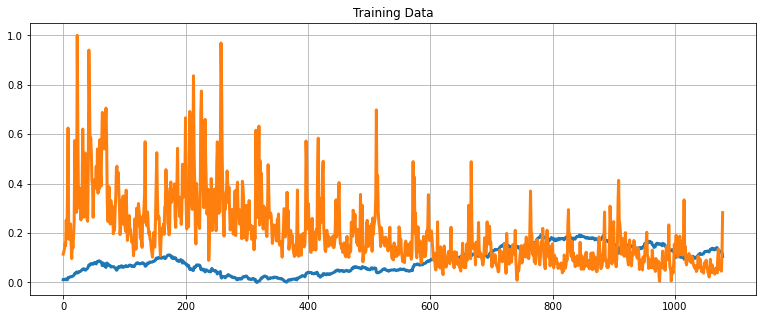

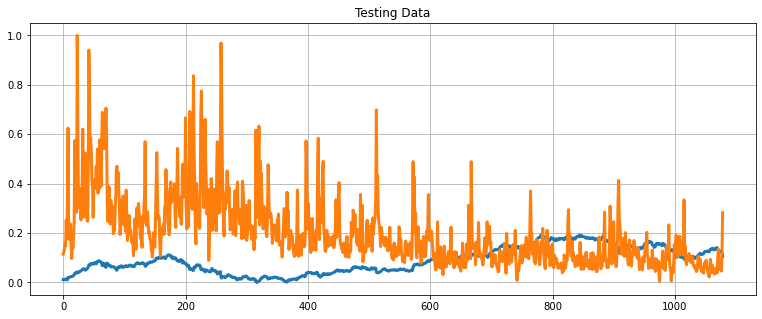

In [21]:
# Define a data plotting function
def show_plot(data, title):
  plt.figure(figsize = (13,5))
  plt.plot(data, linewidth = 3)
  plt.title(title)
  plt.grid()

show_plot(X_train, 'Training Data')
show_plot(X_test, 'Testing Data')

# BUILD AND TRAIN A RIDGE LINEAR REGRESSION MODEL

In [22]:
regression_model = Ridge()

# Test the model and calculate its accuracy 
regression_model.fit(X_train, y_train)

# Make Prediction
lr_accuracy = regression_model.score(X_test, y_test)
print('Ridge Regression Score:', lr_accuracy)

Ridge Regression Score: 0.9235402375540539


In [23]:
# Append the predicted values into a list
predicted_prices = regression_model.predict(X)

In [24]:
predicted = []
for i in predicted_prices:
  predicted.append(i[0])

In [25]:
# Append the close values to the list
close = []
for i in price_volume_target_scaled_df:
  close.append(i[0])

In [26]:
# Create a dataframe based on the dates in the individual stock data
df_predicted = price_volume_target_df[['Date']]

In [27]:
# Add the close values to the dataframe
df_predicted['Close'] = close

In [28]:
# Add the predicted values to the dataframe
df_predicted['Prediction'] = predicted
df_predicted

,Date,Close,Prediction
0,2012-01-12,0.011026,0.039271
1,2012-01-13,0.010462,0.038418
2,2012-01-17,0.012209,0.039053
3,2012-01-18,0.013785,0.038985
4,2012-01-19,0.013299,0.039164
...,...,...,...
2153,2020-08-04,0.957606,0.698486
2154,2020-08-05,0.961583,0.703003
2155,2020-08-06,1.000000,0.726942
2156,2020-08-07,0.972088,0.707701


In [29]:
# Plot the results
#interactive_plot(df_predicted, 'Original Vs. Predictions: Apple Stock(AAPL)')

# TRAIN AN LSTM TIME SERIES MODEL

#### If you want to view APPL / AMZN / ETC: Change 'sp500 HERE!

In [30]:
# Let's test the functions and get individual stock prices and volumes for sp500
price_volume_df = individual_stock(stocks_df, stocks_vol_df, 'sp500')

In [31]:
# Get the close and volume data as training data (Input)
training_data = price_volume_df.iloc[:, 1:3].values

In [32]:
# Normalize the data
sc = MinMaxScaler(feature_range= (0,1))
training_set_scaled = sc.fit_transform(training_data)

In [33]:
# Create the training and testing data, training data contains present day and previous day values
X = []
y = []   
for i in range(1, len(price_volume_df)):
  X.append(training_set_scaled[i-1:i, 0])
  y.append(training_set_scaled[i, 0])

In [34]:
# Convert the data into array format
X = np.array(X)
y = np.array(y)

In [35]:
# Split the data
split = int(0.7 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [36]:
# Reshape the 1D arrays to 3D arrays to feed in the model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [37]:
# Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 150)            91200     
_________________________________________________________________
dropout (Dropout)            (None, 1, 150)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 150)            180600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 150)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense (Dense)                (None, 1)                 151   

In [38]:
# Train the model
history = model.fit(X_train, y_train, epochs= 20, batch_size= 32, validation_split= 0.2)

Epoch 1/20
38/38 [==============================] - 8s 62ms/step - loss: 0.0516 - val_loss: 0.0600
Epoch 2/20
38/38 [==============================] - 1s 14ms/step - loss: 0.0091 - val_loss: 0.0038
Epoch 3/20
38/38 [==============================] - 0s 8ms/step - loss: 8.3167e-04 - val_loss: 4.3237e-04
Epoch 4/20
38/38 [==============================] - 0s 8ms/step - loss: 3.9917e-04 - val_loss: 6.8443e-05
Epoch 5/20
38/38 [==============================] - 0s 8ms/step - loss: 3.7719e-04 - val_loss: 2.2298e-04
Epoch 6/20
38/38 [==============================] - 0s 8ms/step - loss: 3.8296e-04 - val_loss: 2.6274e-04
Epoch 7/20
38/38 [==============================] - 0s 9ms/step - loss: 3.6797e-04 - val_loss: 1.6367e-04
Epoch 8/20
38/38 [==============================] - 0s 8ms/step - loss: 3.0490e-04 - val_loss: 4.3384e-04
Epoch 9/20
38/38 [==============================] - 0s 7ms/step - loss: 2.6665e-04 - val_loss: 6.7167e-05
Epoch 10/20
38/38 [==============================] - 0s 7ms/

In [39]:
# Make prediction
predicted = model.predict(X)

In [40]:
test_predicted = []

for i in predicted:
  test_predicted.append(i[0])

In [41]:
df_predicted = price_volume_df[1:][['Date']]

In [42]:
df_predicted['predictions'] = test_predicted

In [43]:
close = []
for i in training_set_scaled:
  close.append(i[0])

In [44]:
df_predicted['Close'] = close[1:]
df_predicted

,Date,predictions,Close
1,2012-01-13,0.013117,0.005242
2,2012-01-17,0.010090,0.007414
3,2012-01-18,0.012253,0.014231
4,2012-01-19,0.019040,0.017295
5,2012-01-20,0.022092,0.017713
...,...,...,...
2154,2020-08-05,0.921312,0.972307
2155,2020-08-06,0.930061,0.982453
2156,2020-08-07,0.938837,0.983459
2157,2020-08-10,0.939706,0.987819


In [45]:
# Plot the results
#interactive_plot(df_predicted, 'Original Vs Predictions: SP500')